## Dataset
https://www.kaggle.com/datasets/dansbecker/5-celebrity-faces-dataset?resource=download

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Detect Faces

In [ ]:
!sudo pip install mtcnn

In [11]:
import mtcnn
print(mtcnn.__version__)

0.1.0


In [10]:
#import Lib
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
from os.path import isdir
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
from keras_facenet import FaceNet

from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
import pandas as pd




1/1 [==============================] - 0s 155ms/step
1 (160, 160, 3)
1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 156ms/step
2 (160, 160, 3)
1/1 [==============================] - 0s 248ms/step
3 (160, 160, 3)
1/1 [==============================] - 0s 147ms/step
4 (160, 160, 3)
1/1 [==============================] - 0s 139ms/step
5 (160, 160, 3)
1/1 [==============================] - 0s 146ms/step
6 (160, 160, 3)
1/1 [==============================] - 0s 146ms/step
7 (160, 160, 3)
1/1 [==============================] - 0s 188ms/step
8 (160, 160, 3)
1/1 [==============================] - 0s 261ms/step
9 (160, 160, 3)
1/1 [==============================] - 0s 235ms/step
10 (160, 160, 3)
1/1 [==============================] - 0s 143ms/step
11 (160, 160, 3)
1/1 [==============================] - 0s 150ms/step
12 (160, 160, 3)
1/1 [==============================] - 0s 152ms/step
13 (160, 160, 3)
1/1 [==============================] - 0s 159ms/step
14 (160, 160, 3)


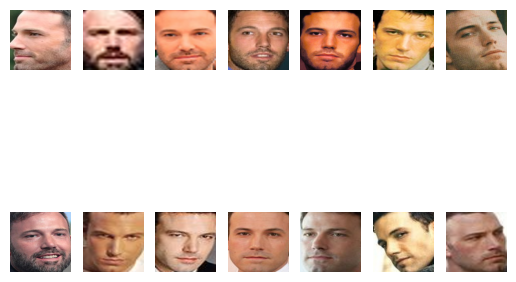

In [12]:
# demonstrate face detection on 5 Celebrity Faces Dataset


# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# specify folder to plot
folder = '/content/drive/MyDrive/Data/FiveCelebPhotos/train/ben_afflek/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path)
	print(i, face.shape)
	# plot
	pyplot.subplot(2, 7, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()

## Utility: Load dataset from all folders and extract faces

In [13]:
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

In [14]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

In [15]:
from numpy import savez_compressed
# load train dataset
trainX, trainy = load_dataset('/content/drive/MyDrive/Data/FiveCelebPhotos/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/drive/MyDrive/Data/FiveCelebPhotos/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
savez_compressed('FiveCelebPhotos.npz', trainX, trainy, testX, testy)

1/1 [==============================] - 0s 190ms/step
>loaded 14 examples for class: ben_afflek
1/1 [==============================] - 0s 148ms/step
>loaded 19 examples for class: madonna
1/1 [==============================] - 0s 145ms/step
>loaded 22 examples for class: mindy_kaling
1/1 [==============================] - 0s 208ms/step
>loaded 17 examples for class: elton_john
1/1 [==============================] - 0s 168ms/step
>loaded 21 examples for class: jerry_seinfeld
(93, 160, 160, 3) (93,)
1/1 [==============================] - 0s 206ms/step
>loaded 5 examples for class: elton_john
1/1 [==============================] - 0s 155ms/step
>loaded 5 examples for class: ben_afflek
1/1 [==============================] - 0s 276ms/step
>loaded 5 examples for class: madonna
1/1 [==============================] - 0s 250ms/step
>loaded 5 examples for class: mindy_kaling
1/1 [==============================] - 0s 147ms/step
>loaded 5 examples for class: jerry_seinfeld
(25, 160, 160, 3) (25,)


## Face Recognition using FaceNet
https://www.syntric.ai/post/introduction-to-the-facenet-architecture

https://arxiv.org/pdf/1503.03832.pdf

In [16]:
!pip install keras-facenet

In [17]:

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.embeddings(samples)
	return yhat[0]

# load the face dataset
data = load('/content/FiveCelebPhotos.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
###model = load_model('facenet_keras.h5')
model = FaceNet()

print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('FiveCelebPhotos-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
Loaded Model
1/1 [==============================] - 0s 117ms/step
(93, 512)
1/1 [==============================] - 0s 105ms/step
(25, 512)


In [18]:
# develop a classifier for the 5 Celebrity Faces Dataset
# load faces
data = load('FiveCelebPhotos.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('FiveCelebPhotos-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
df1 = pd.DataFrame(trainy, columns =['state'])
code = pd.DataFrame(df1['state'].unique())
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
#print encoded
df2 = pd.DataFrame(trainy) #out_encoder
encode = pd.DataFrame(df2[0].unique())
refer = pd.DataFrame()
refer['code']=code
refer['encode']=encode
print(refer)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)


             code  encode
0      ben_afflek       0
1         madonna       3
2    mindy_kaling       4
3      elton_john       1
4  jerry_seinfeld       2


SVC(kernel='linear', probability=True)

Predicted: mindy_kaling (15.900)
Expected: mindy_kaling


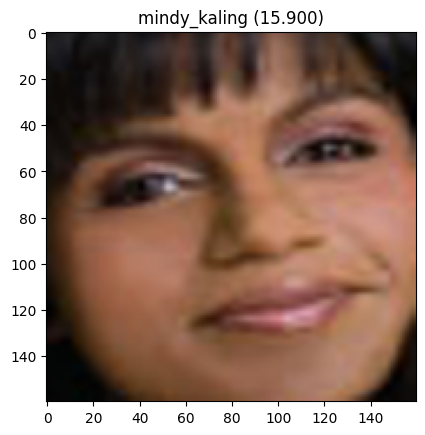

In [21]:
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [21]:
import pickle
pickle.dump(model, open('/content/drive/MyDrive/final_prediction.pickle', 'wb'))
pickle.dump(in_encoder, open('/content/drive/MyDrive/scaler.pickle', 'wb'))